In [16]:
import numpy as np
from sequence_jacobian import het, interpolate, misc, grids,utilities,create_model,simple
import copy

from matplotlib import pyplot as plt

import matplotlib.pyplot as plt

#jupyter nbconvert main.ipynb --to slides --SlidesExporter.reveal_theme=seirf --SlidesExporter.reveal_scroll=True^C

# TSP Lecture - HA Models

Jamie Lenney 

Dec 2025 

Code/slides: https://github.com/s0840389/TSP_HA


## Objectives

* Motivate incomplete markets 

* Understand how income risk and borrowing constraints underpin HA model mechanisms

* Know how to solve a HA

* Examine the properties of a Hugget model

**Further reading** - Ljungqvist and Sargent Recursive Macroeconmic Theory chapters: 17,18 


## Incomplete Markets 

What is this? 

* Can think of a representative agent model as a model where individuals have written contracts to hedge against all risk
    * They are still exposed to aggregate risk
    * Can still have complete markets models with wealth distribution but all agents consumption would move proportinally in the same way. 

* When this is not possible we have incomplete markets
    * e.g. There are not sufficient assets/contracts to trade. 

* Incomplete markets creates incentives for self-insurance
    * Saving for a 'rainy day'




## Consumption Savings Problem

Households($i$) maximize lifetime expected utility:

$$\max_{\{c_t\}_{t=0}^{\infty}} \mathbb{E}_0 \sum_{t=0}^{\infty} \beta^t u(c_t)$$

where:
- $c_t$ = consumption at time $t$
- $\beta \in (0,1)$ = discount factor
- $u(c)$ = instantaneous utility function (typically CRRA $\frac{c^{1-\sigma}}{1-\sigma}$)



## Utility function properties

1. **Strictly increasing**: $u'(c) > 0$ 
   - More consumption is always preferred

2. **Strictly concave**: $u''(c) < 0$
   - Diminishing marginal utility
   - Induces consumption smoothing

3. **Positive third derivative: Prudence**: $u'''(c) > 0$

    - **Prudence** means the marginal utility function is convex.
    - **Key implication**: Creates a **precautionary savings motive**
        - When facing income risk, agents save more as insurance against bad shocks
        - Expected marginal utility exceeds marginal utility of expected consumption: $\mathbb{E}[u'(c')] > u'(\mathbb{E}[c'])$ (Jensen's inequality)

4. **Inada conditions**: 
   - $\lim_{c \to 0} u'(c) = \infty$ ensures $c > 0$ always
   - $\lim_{c \to \infty} u'(c) = 0$ ensures interior solutions

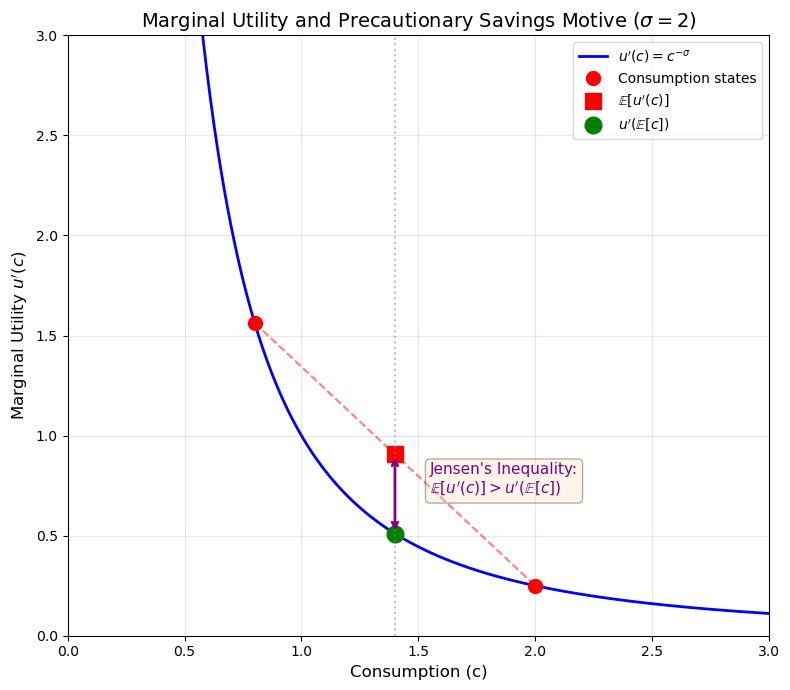

In [17]:

# CRRA utility function and derivatives
sigma = 2

def u(c, sigma):
    """CRRA utility function"""
    if sigma == 1:
        return np.log(c)
    else:
        return (c**(1-sigma))/(1-sigma)

def u_prime(c, sigma):
    """Marginal utility"""
    return c**(-sigma)

# Create consumption grid
c = np.linspace(0.1, 3, 200)

# Calculate marginal utility
u_prime_c = u_prime(c, sigma)

# Illustrate Jensen's inequality
# Two consumption states (high and low)
c_low = 0.8
c_high = 2.0
c_expected = (c_low + c_high) / 2  # E[c]

# Marginal utilities
u_prime_low = u_prime(c_low, sigma)
u_prime_high = u_prime(c_high, sigma)
u_prime_expected_c = u_prime(c_expected, sigma)  # u'(E[c])
expected_u_prime = (u_prime_low + u_prime_high) / 2  # E[u'(c)]

# Create figure
fig, ax = plt.subplots(figsize=(8, 7))

# Plot marginal utility function
ax.plot(c, u_prime_c, 'b-', linewidth=2, label="$u'(c) = c^{-\\sigma}$")

# Mark the two consumption states
ax.plot([c_low, c_high], [u_prime_low, u_prime_high], 'ro', markersize=10, label='Consumption states')

# Show E[u'(c)] - the average of marginal utilities
ax.plot([c_low, c_high], [u_prime_low, u_prime_high], 'r--', linewidth=1.5, alpha=0.5)
ax.plot(c_expected, expected_u_prime, 'rs', markersize=12, label="$\\mathbb{E}[u'(c)]$")

# Show u'(E[c]) - marginal utility at expected consumption
ax.plot(c_expected, u_prime_expected_c, 'go', markersize=12, label="$u'(\\mathbb{E}[c])$")

# Add vertical line at E[c]
ax.axvline(c_expected, color='gray', linestyle=':', alpha=0.5)

# Annotate Jensen's inequality
ax.annotate('', xy=(c_expected, expected_u_prime), xytext=(c_expected, u_prime_expected_c),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax.text(c_expected + 0.15, (expected_u_prime + u_prime_expected_c)/2, 
        "Jensen's Inequality:\n$\\mathbb{E}[u'(c)] > u'(\\mathbb{E}[c])$",
        fontsize=11, color='purple', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

ax.set_xlabel('Consumption (c)', fontsize=12)
ax.set_ylabel("Marginal Utility $u'(c)$", fontsize=12)
ax.set_title(f'Marginal Utility and Precautionary Savings Motive ($\\sigma = {sigma}$)', fontsize=14)
ax.legend(fontsize=10, loc='upper right')
ax.grid(alpha=0.3)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

fig.tight_layout()
fig.savefig('marginal_utility_jensens_inequality.png', dpi=150)



![Marginal utilty](marginal_utility_jensens_inequality.png)


## Constraints

#### Budget Constraint
$$c_t + a_{t+1} = (1+r_t)a_t + \underbrace{z_t w_t}_{y_t}$$

- $a_t$ = assets at beginning of period $t$
- $r_t$ = interest rate
- $w_t z_t$ = labor income (stochastic)

#### Borrowing Constraint
$$a_{t+1} \geq \underline{a}$$

- $\underline{a}$ = borrowing limit
- Common cases: $\underline{a} = 0$ (no borrowing) or $\underline{a} < 0$ (some debt allowed)

### Natural borrowing constraint

Under worst case scenario need to be able to afford interest payments

$$\underline{a}=\frac{w_{low}z_{low}}{r_{high}}$$

### Income Process

#### Stochastic Income
Labor productivity (income) follows a Markov process:

$$\log z_t = \rho \log z_{t-1} + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2)$$

Can be discretized into:
- $z_t \in \{z_1, z_2, ..., z_N\}$ (finite states)
- Transition matrix $\Pi$ where $\Pi_{ij} = \Pr(z_{t+1} = z_j | z_t = z_i)$

**Key feature**: Households face **uninsurable idiosyncratic risk**
- Cannot fully smooth consumption
- Need to self-insure through savings



### Bellman Equation

#### Recursive Formulation
$$V(a, y) = \max_{a' \geq \underline{a}} \left\{ u(c) + \beta \mathbb{E}[V(a', y') | y] \right\}$$

subject to:
$$c = (1+r)a + y - a'$$

where:
- $V(a,y)$ = value of having assets $a$ and income $y$ today
- $a'$ = assets tomorrow (choice variable)
- $\mathbb{E}[V(a', y') | y] = \sum_{y'} \Pi(y'|y) V(a', y')$

- **State variables**: $(a, y)$

- **Choice variables**: $(c)$


### First Order Conditions

#### Lagrangian
$$\mathcal{L} = u(c) + \beta \mathbb{E}[V(a')] + \lambda(a' - \underline{a})$$

Derivative of $\mathcal{L}$ wrpt to $a'$

$$0 = -u'(c) +\beta \mathbb{E}[V_a'(a',y')] +\lambda $$

Derivative of $V(a,y)$ wrpt to $a$

$$ V'_a(a,y) = \beta (1+r)\mathbb{E}[V_a'(a',y')]+(1+r)\lambda$$

Putting togethor we have

$$ V_a'(a,y) = (1+r)u'(c)$$

And our Euler equation

$$ u'(c)  = \beta \mathbb{E}[(1+r')u'(c')]+\lambda$$


### Complementary Slackness
1. $\lambda \geq 0$
2. $a' - \underline{a} \geq 0$
3. $\lambda (a' - \underline{a}) = 0$

* Binding constraint ($\lambda>0$)
    - $ u'(c)  = \beta \mathbb{E}[(1+r')u'(c')]+\lambda$
    
    - implies consumption is below what agent would want

* Otherwise
    - $ u'(c)  = \beta \mathbb{E}[(1+r')u'(c')]$

## Value Function Iteration (VFI)

- Goal: solve household problem by iterating on the Bellman equation directly to find the value function and policy functions.

- Core idea
  - For each state (productivity z, assets a), maximize over all possible asset choices a' to find the value function.
  - Bellman equation: 
  
  $$V^{j}(z,a) = max_{a'} { u(c) + β E[V^{j-1}(z',a') | z] }$$

  - find best choice, update value function and continue until it converges $\lVert V^{j}-V^{j-1}\rVert \leq \epsilon$



 ## Value Function Iteration (VFI)

- Algorithm (one backward step)

  1. For each (z, a) state, construct V(z,a,a') value for each possible a' choice on grid

  2. Calculate value: $V = u(c) + β E[V_{t+1}(z', a')]$

  3. Find optimal choice: $a* = \max_{a'} V$

  4. Store $V(z,a) = \max{V}$ and policy $a(z,a) = a*$



## Value Function Iteration (VFI)

- Advantages
  - Simple and robust;
  - No need for invertible Euler equation
  - Can handle non-convexities, occasionally binding constraints
  

- Limitations / notes
  - Computationally expensive: O(nZ × nA²) per iteration
  - Policy functions can be jagged/non-smooth with coarse grids
  - Requires fine grids (nA = 2000+) for smooth policies
  - Much slower than other methods (e.g. EGM) for standard models

In [18]:
cali={} # calibration

# household 
cali['beta']=0.98 # patience
cali['sigma']=2 # risk aversion
cali['eis']=1/cali['sigma'] # intertemporal elasticity of substitution
cali['bc']=-0.2
cali['borwedge']=0.0

cali['rho_z']=0.97
cali['sd_z']=0.6

# aggregate economy
cali['r']=0.04/4
cali['w']=1.0
cali['govT']=0

# discretization
cali['nA']=2000
cali['nZ']=5
cali['amax']=125


In [19]:

## Household problem

def make_grid(bc, amax, nA,nZ,rho_z,sd_z):
    
    z_grid, pi_z, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sd_z, N=nZ)  
    a_grid = utilities.discretize.nonlinspace(amax,nA ,1.2, amin = bc) # normalized grid between zero and one with n_a number of points
    
    return z_grid, pi_z, Pi, a_grid


def income(w,r,borwedge,a_grid,z_grid,govT):

    rexpand=r*np.ones_like(a_grid) 
    rexpand[a_grid<0]=r+borwedge
    coh = (1+rexpand)*a_grid + w*z_grid[:, np.newaxis]+govT

    return coh


def household_init( r, coh, eis): # initial guess for marginal value function
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va


In [20]:
def household_vfit_init( r, coh, eis): # initial guess for marginal value function
    V = (0.1 * coh)**(1-1/eis)/(1-1/eis)  # utility level
    return V

@het(exogenous='Pi', policy='a', backward='V', backward_init=household_vfit_init)
def household_vfit(V_p, a_grid, r, coh, beta, eis,nZ):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    V_p     : array (nE, nA), expected  value function next period
    a_grid   : array (nA), asset grid
    z_grid   : array (nE), producticity grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount factor
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    V : array (nE, nA), value function today
    a  : array (nE, nA), asset policy today
    c  : array (nE, nA), consumption policy today
    """

    c=coh[:,:,np.newaxis]-a_grid[np.newaxis,np.newaxis,:]
    Vupdate=c**(1-1/eis)/(1-1/eis)+beta*V_p[:,np.newaxis,:]
    Vupdate[c<=0]=-1e10
    v_choice = np.argmax(Vupdate, axis=2)
    
    V = np.take_along_axis(Vupdate, v_choice[:, :, np.newaxis], axis=2).squeeze(axis=2)
    a = a_grid[v_choice]
    c = coh - a
    
    return V,a,c


hh_vfit=household_vfit.add_hetinputs([make_grid,income])

cali_vfit=copy.deepcopy(cali)
ss0_vfit=hh_vfit.steady_state(cali_vfit)

c_vfit=ss0_vfit.internals['household_vfit']['c']
D_vfit=ss0_vfit.internals['household_vfit']['D']

from matplotlib import pyplot as plt
a_grid_vfit=ss0_vfit.internals['household_vfit']['a_grid']

D_vfit=ss0_vfit.internals['household_vfit']['D']


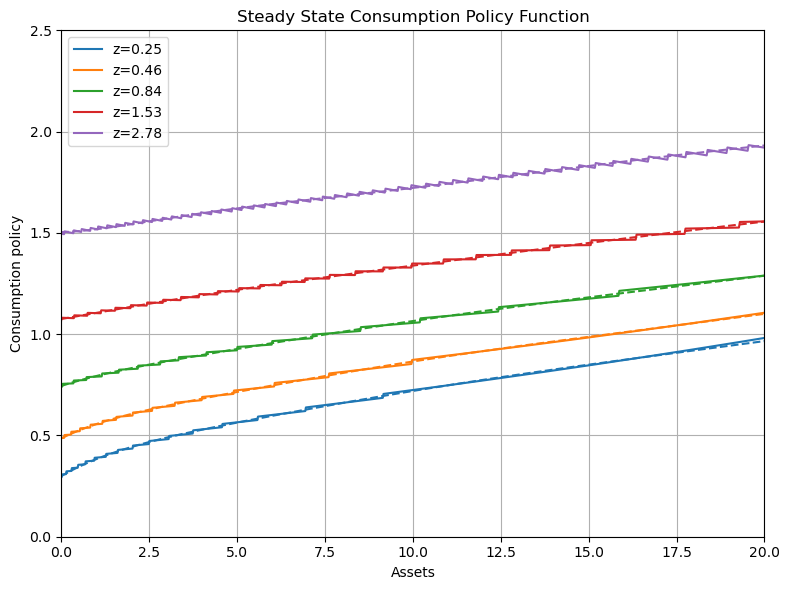

In [21]:
from numpy.polynomial import Polynomial


# Polynomial approximation to c_vfit for each z

poly_degree = 15
c_poly_fits = []

for i in range(cali_vfit['nZ']):
    p = Polynomial.fit(a_grid_vfit, c_vfit[i, :], poly_degree)
    c_poly_fits.append(p)

fig_vfit, ax1 = plt.subplots(1, 1, figsize=(8, 6))

# Get colors from default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, p in enumerate(c_poly_fits):
    ax1.plot(a_grid_vfit, p(a_grid_vfit), linestyle='--', color=colors[i])
    ax1.plot(a_grid_vfit, c_vfit[i,:], label='z='+str(round(ss0_vfit.internals['household_vfit']['z_grid'][i],2)), color=colors[i])

ax1.set_xlabel('Assets')
ax1.set_ylabel('Consumption policy')
ax1.set_title('Steady State Consumption Policy Function')
ax1.legend()
ax1.grid()
ax1.set_xlim(0,20)
ax1.set_ylim(0,2.5)


fig_vfit.tight_layout()

fig_vfit.savefig('steady_state_consumption_policy_vfit.png')

### Consumption Functions

![vfn](steady_state_consumption_policy_vfit.png)


## Endogenous Gridpoint Method (EGM)

- Goal: solve household Euler equation without repeated root-finding at every asset grid point — faster and smoother than brute-force VFI.

- Core idea
  - Use Euler equation to compute optimal consumption on the *next-period* grid of assets (endogenous grid), then recover the implied current assets.

  - For CRRA utility: $u'(c) = c^{-\sigma}$. 
  
  - Euler gives $u'(c_t) = β(1+r) E[u'(c_{t+1})]$  ⇒  $c_t = [β(1+r) E[u'(c_{t+1})]]^{\frac{-1}{\sigma}}$


## Endogenous Gridpoint Method (EGM)

- Algorithm (one backward step)

  1. For each (z,a') Compute expected marginal utility next period: $m = β E[(1+r') u'(c(z',a')))]$.
      - $m(z,a')= \beta \sum_{z'} \Pi(z'|z)(1+r')u'(c(z,a'))$

  2. Invert marginal utility to get c at each next-period asset grid point: $c(z,?) = m^{\frac{-1}{\sigma}}$.

  3. Compute implied current assets: $a = \frac{ a'+c-y}{1+r}$ 
      - given I choose a', when i have z, it implies I have $a$ today

  4. Interpolate policy ($a$ → $c$) from the endogenous $a_t$ back onto the exogenous asset grid.

  5. Enforce borrowing constraint: where implied $a'$ < $\underline{a}$ set $a' = \underline{a}$ and recompute $c = (1+r)a +y - a'$.




## Endogenous Gridpoint Method (EGM)

- Advantages
  - No inner-loop maximization; vectorizable and much faster.
  - Produces smooth consumption/savings policies when monotonicity holds.

- Limitations / notes
  - Requires invertible Euler equation (works easily with CRRA).

In [22]:
@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, r, coh, beta, eis,nZ):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (nE, nA), expected marginal value of assets next period
    a_grid   : array (nA), asset grid
    z_grid   : array (nE), producticity grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount factor
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (nE, nA), marginal value of assets today
    c  : array (nE, nA), consumption policy today
    a  : array (nE, nA), asset policy today [a']
    """

    uc_nextgrid= beta * Va_p

    c_today = uc_nextgrid ** (-(eis))
    
    a = interpolate.interpolate_y(c_today + a_grid, coh, a_grid) # when i have coh(t)=c_today(t) + a_grid(t+1) i chose a_grid, what do i choose if on the coh grid today?
    misc.setmin(a, a_grid[0]) # apply borrowing constraint
    c = coh - a # work out consumptin policy today on the a_grid
    Va = (1 + r) * c ** (-1 / (eis)) #calculate marginal value today on the a_grid

    return Va, a, c

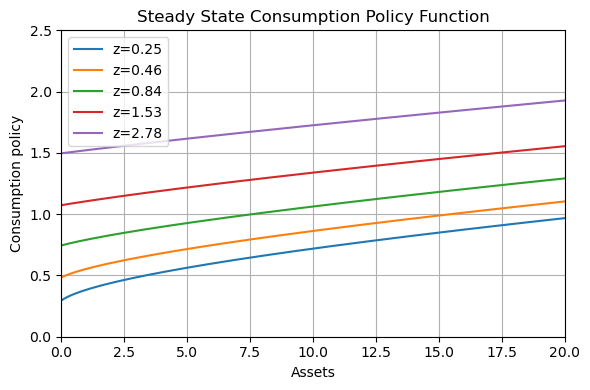

In [23]:
cali['nA']=500 # need less points for 

hh=household.add_hetinputs([make_grid,income])
ss0=hh.steady_state(cali)

a_grid=ss0.internals['household']['a_grid']

D=ss0.internals['household']['D']

fig, (ax) = plt.subplots(1, 1, figsize=(6, 4))

# Left panel: Consumption policy
ax.plot(a_grid, ss0.internals['household']['c'][:,:].T)
ax.set_xlabel('Assets')
ax.set_ylabel('Consumption policy')
ax.set_title('Steady State Consumption Policy Function')
ax.legend(['z='+str(round(z,2)) for z in ss0.internals['household']['z_grid']])
ax.grid()
ax.set_xlim(0,20)
ax.set_ylim(0,2.5)

fig.tight_layout()


fig.savefig('steady_state_consumption_policy.png')

### Consumption Function (EGM)

![Economic Model](steady_state_consumption_policy.png)




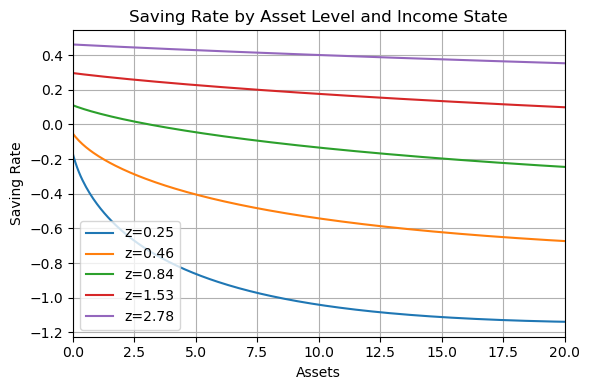

In [24]:
inc=ss0.internals['household']['coh']-a_grid
c=ss0.internals['household']['c']

s=1-c/inc

fig_sr, ax2 = plt.subplots(1, 1, figsize=(6, 4))

for i in range(cali['nZ']):
    ax2.plot(a_grid, s[i,:], label='z='+str(round(ss0.internals['household']['z_grid'][i],2)))
ax2.set_xlabel('Assets')
ax2.set_ylabel('Saving Rate')
ax2.set_title('Saving Rate by Asset Level and Income State')
ax2.legend()
ax2.grid()
ax2.set_xlim(0,20)
fig_sr.tight_layout()
fig_sr.savefig('saving_rate_by_asset_and_income.png', dpi=150)

![Savings](saving_rate_by_asset_and_income.png)


## Forward Iteration: Computing the Distribution

**Given policy functions**, we need to find the stationary distribution of households over $(z,a)$ states.

**Key objects:**
- Policy function: $a'(z,a)$ — optimal asset choice
- Transition matrix for income: $\Pi(z'|z)$ — probability of $z \to z'$
- Distribution: $D_t(z,a)$ — mass of households at state $(z,a)$ at time $t$

**Forward iteration equation:**

$$D_{t+1}(z',a') = \sum_{z,a} D_t(z,a) \cdot \mathbb{1}[a'(z,a) = a'] \cdot \Pi(z'|z)$$

**In words:** The mass at $(z',a')$ tomorrow equals the sum of all households who:
1. Choose $a'$ as their savings today
2. Transition from $z$ to $z'$ with probability $\Pi(z'|z)$

**Matrix representation:** We can write this as a **large transition matrix** $\Lambda$ where:

$$D_{t+1} = \Lambda D_t$$

where $D_t$ is vectorized over all $(z,a)$ states.

## Finding the Ergodic Distribution

**Steady state condition:** $D^* = \Lambda D^*$

This is an **eigenvalue problem** with eigenvalue = 1.

**Two approaches:**

1. **Power iteration** (iterate until convergence):
   - Start with initial guess $D_0$ (e.g., uniform distribution)
   - Iterate: $D_{t+1} = \Lambda D_t$
   - Continue until $\|D_{t+1} - D_t\| < \epsilon$

2. **Eigenvalue method** (fast and exact):
   - Find eigenvector of $\Lambda$ corresponding to eigenvalue = 1
   - $\Lambda v = 1 \cdot v$ where $v$ is the stationary distribution
   - Normalize: $D^* = v / \sum v$


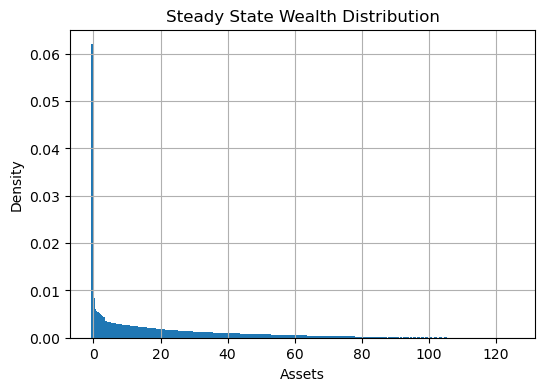

In [25]:
fig_ergdist, ax2 = plt.subplots(1, 1, figsize=(6, 4))

ax2.bar(a_grid, np.sum(D,axis=0))
ax2.set_xlabel('Assets')
ax2.set_ylabel('Density')
ax2.set_title('Steady State Wealth Distribution')
ax2.grid()
fig_ergdist.savefig('steady_state_wealth_distribution.png', dpi=150)


![Aggregate Savings](steady_state_wealth_distribution.png)


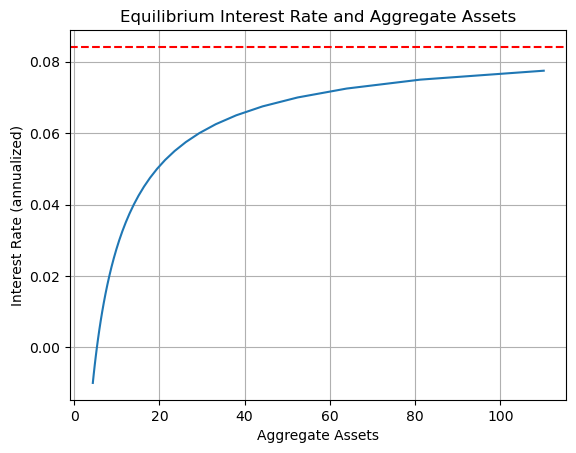

In [26]:
import copy 

r_grid=np.arange(-0.01,0.08,0.0025)/4
A_grid=np.zeros_like(r_grid)
ss_list=[]

cali_r=copy.deepcopy(cali)

for r in r_grid:
    cali_r['r']=r
    ss=hh.steady_state(cali_r)
    ss_list.append(ss)
    A_grid[np.where(r_grid==r)[0][0]]=ss['A']

plt.plot(A_grid,r_grid*4)
plt.ylabel('Interest Rate (annualized)')
plt.xlabel('Aggregate Assets')
plt.title('Equilibrium Interest Rate and Aggregate Assets')
plt.axhline(y=1/cali['beta']**4-1, color='r', linestyle='--', label='CM baseline')
plt.grid()

plt.savefig('equilibrium_interest_rate_vs_aggregate_assets.png')


![Aggregate Savings diff bc](equilibrium_interest_rate_vs_aggregate_assets.png)



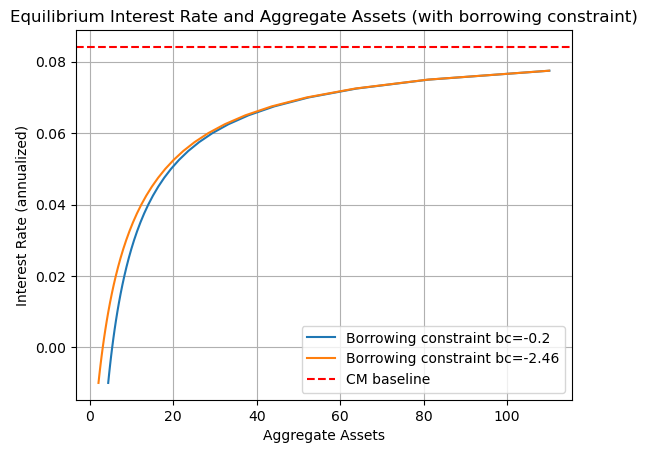

In [27]:
cali_hbc=copy.deepcopy(cali)
cali_hbc['bc']=-2

cali_nbc=copy.deepcopy(cali)
cali_nbc['bc']=-ss0.internals['household']['coh'][0,0]/(1/cali['beta']-1)

A_grid_hbc=np.zeros_like(r_grid)
A_grid_nbc=np.zeros_like(r_grid)

for r in r_grid:
    cali_hbc['r']=r
    cali_nbc['r']=r
    ss_hbc=hh.steady_state(cali_hbc)
    ss_nbc=hh.steady_state(cali_nbc)
    A_grid_hbc[np.where(r_grid==r)[0][0]]=ss_hbc['A']
    A_grid_nbc[np.where(r_grid==r)[0][0]]=ss_nbc['A']

plt.plot(A_grid,r_grid*4,label='Borrowing constraint bc=-0.2')
#plt.plot(A_grid_hbc,r_grid*4,label='With borrowing constraint bc=-2')
plt.plot(A_grid_nbc,r_grid*4,label='Borrowing constraint bc='+str(np.round(cali_nbc['bc'],2)))
plt.ylabel('Interest Rate (annualized)')
plt.xlabel('Aggregate Assets')
plt.title('Equilibrium Interest Rate and Aggregate Assets (with borrowing constraint)')
plt.axhline(y=1/cali['beta']**4-1, color='r', linestyle='--', label='CM baseline')
plt.grid()
plt.legend()

plt.savefig('aggregate_assets_borrowing_constraints.png')


![Aggregate Savings diff bc](aggregate_assets_borrowing_constraints.png)



## Aggregate Dynamics 

* So far considered a model at it's steady state

* Generally we want to think about aggregate dynamics

* With HA models, now common to use peturbation methods around steady state to compute dynamic responses to shocks
    - e.g. SGU method (Bayer et al, 2024) or Sequence Space Jacobian (Auclert et al, 2021)

* All rely on taking derivatives around steady state and solving for policy functions that maintain equlibrium equations. 

## TFP Shock in a Hugget model

$ Y_t=Z_t \int z_i di$ 

$A_t=B$

$\tau_t=r_tB$

$ \log{Z_t}=\rho \log{Z_{t-1}}+\epsilon_t$



* Fixed level of saving supported by fixed issuance of government bonds $B$. 
* Output fluctuates with aggregate TFP Process
* Interest rate fluctuates to ensure savings supply equals demand
* Normalise such that $\int z_i di=1$







In [28]:
@simple
def wage(Z): 
    w=Z
    Y=Z
    return w,Y

@simple
def mkt_clearing(A,B,Y,C):
    asset_mkt=A-B
    goods_mkt=C-Y
    return asset_mkt, goods_mkt

@simple
def gov(r,B):
    govT=-r*B
    return govT


In [29]:

cali_full=copy.deepcopy(cali)
cali_full['B']=8
cali_full['Z']=1

hugget_full = create_model([hh,wage,gov,mkt_clearing], name="Hugget")


unknowns_ss = {'r': 0.015}
targets_ss = {'asset_mkt': 0}

ss0_full = hugget_full.solve_steady_state(cali_full, unknowns_ss, targets_ss, solver="hybr")

print('r:',ss0_full['r'])
print('Good_mkt:',ss0_full['goods_mkt'])

# dynamics

Ghugget= hugget_full.solve_jacobian(ss0_full, ['r'], ['asset_mkt'], ['Z'], T=300)



r: 0.0038574596889343112
Good_mkt: 5.67532842943308e-09


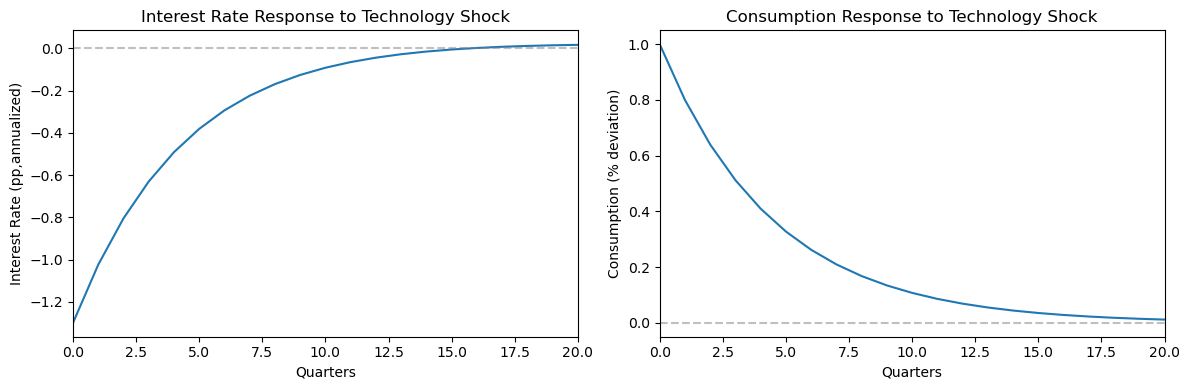

In [30]:
Zshock=0.01*np.power(0.8, np.arange(0,300))

fig_dyn, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(Ghugget['r']['Z']@Zshock*400, label='Asset Market')
ax[0].set_title('Interest Rate Response to Technology Shock')
ax[0].set_xlabel('Quarters')
ax[0].set_ylabel('Interest Rate (pp,annualized)')
ax[0].set_xlim(0,20)
ax[0].axhline(0, color='gray', linestyle='--', alpha=0.5)

ax[1].plot(Ghugget['C']['Z']@Zshock/ss0_full['C']*100, label='Goods Market')

ax[1].set_title('Consumption Response to Technology Shock')
ax[1].set_xlabel('Quarters')
ax[1].set_ylabel('Consumption (% deviation)')
ax[1].set_xlim(0,20)
ax[1].axhline(0, color='gray', linestyle='--', alpha=0.5)

fig_dyn.tight_layout()
fig_dyn.savefig('hugget_dynamics.png', dpi=150)


## Response to a 1 pct TFP shock

![TFP shock](hugget_dynamics.png)

* Nature of shock means today is better than tomorrow

* Households want to save more

* Interest rate has to fall to bring saving demand into equilibrium with supply ($r^*$ falls)